In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
from timezonefinder import TimezoneFinder
import pytz

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import random

### Load Data

In [ ]:
# X = pd.read_csv('../results/csvs/training_data_2022-11_to_2023-03.csv')
X = pd.read_csv('../results/csvs/corrected_training_data_2022-11_to_2023-03.csv')
y = pd.read_csv('../data/IrvineSpectrumCenter_parking_2022-11_to_2023-03.csv')
lot_ids = list(X['pk_lot'].unique())
y = y[y['pk_lot'].isin(lot_ids)]

# remove the -8:00 from the end of the timestamp. I didn't mean to add it in the first place
# X['timestamp'] = X['timestamp'].apply(lambda x: x[:-6])
# X['timestamp'] = pd.to_datetime(X['timestamp'])
# X['timestamp'] = X['timestamp'].dt.tz_localize('UTC')

# convert timestamp to datetime when the rows have different timezones
X['timestamp'] = pd.to_datetime(X['timestamp'], utc=True)
X['timestamp'] = X['timestamp'].dt.tz_convert('US/Pacific')

# sort by timestamp
X = X.sort_values(by=['timestamp'])
X['timestamp'] = X['timestamp'].dt.tz_convert('US/Pacific')

y['dt_start_date'] = pd.to_datetime(y['dt_start_date'])
y['dt_start_date'] = y['dt_start_date'].dt.round('h')
y['dt_start_date'] = y['dt_start_date'].dt.tz_convert('US/Pacific')
y.drop(columns=['dt_end_date', 'pk_lot_alias', 'f_occupancy_rank'], inplace=True)
X = X.sort_values(by=['timestamp'])
y = y.sort_values(by=['dt_start_date'])
display(X.head(10))
display(y.head(10))

Check that we have adequate data coverage (temporally speaking)

In [ ]:
# plot the hours for which we have some data
plt.figure(figsize=(15, 5))
plt.plot(X['timestamp'], X['avg_log_prob'])
plt.xlabel('Time')
plt.ylabel('avg_log_prob')
plt.title('Training data')
plt.show()

plt.figure(figsize=(15, 5))
df = X[(X['timestamp'] <= '2022-12-15') & (X['pk_lot'] == 381381)].copy()
# sort by timestamp
df = df.sort_values(by=['timestamp'])
plt.plot(df['timestamp'], df['avg_log_prob'])
plt.show()

Prepare the ground truth and join it with the training data

In [ ]:
y['timestamp'] = y['dt_start_date'].dt.round('h', ambiguous='NaT')
agg_dict = {'f_pct_occ': 'mean', 'i_avail': 'mean', 'i_occ': 'mean',
            'location': 'first', 'geometry': 'first',}
y = y.groupby(['timestamp', 'pk_lot']).agg(agg_dict).reset_index()
display(y)

In [ ]:
# plot f_pct_occ vs. timestamp for y for first week for random lot
lot_id = np.random.choice(lot_ids)
week_df = y[(y['timestamp'] < '2023-01-08') & (y['pk_lot'] == lot_id)]
plt.plot(week_df['timestamp'], week_df['f_pct_occ'])
plt.xlabel('Date')
plt.ylabel('Occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.show()

In [ ]:
print(X.shape)
print(y.shape)

# join X and y on timestamp and pk_lot
df = pd.merge(X, y, on=['timestamp', 'pk_lot'], how='inner')
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['timestamp'].dt.dayofweek >= 5

print(df.shape)
display(df.head(2))

### Basic linear regression

In [ ]:


# # input_features = ['wasserstein', 'avg_hotspot_distance', 'hour', 'day_of_week']
# input_features = ['wasserstein', 'avg_hotspot_distance', 'day_of_week']

# X = df[input_features].values
# y = df['f_pct_occ'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# model = LinearRegression()

# # train model
# model.fit(X_train, y_train)

# # evaluate model
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f'MSE: {mse}')


In [ ]:
# # plot each input feature vs. f_pct_occ
# for feat in input_features:
#     plt.scatter(df[feat], df['f_pct_occ'], alpha=0.3)
#     plt.xlabel(feat)
#     plt.ylabel('f_pct_occ')
#     plt.title(f'{feat} vs. f_pct_occ')
#     plt.show()

In [ ]:
# # plot predictions vs. true values
# plt.scatter(y_test, y_pred)
# # line of best fit
# m, b = np.polyfit(y_test, y_pred, 1)
# plt.plot(y_test, m*y_test + b, color='red')
# plt.plot([0, 100], [0, 100], color='black', linestyle='--')
# plt.xlim(0, 100)
# plt.ylim(0, 100)

# plt.xlabel('True')
# plt.ylabel('Predicted')
# plt.title('Linear Regression Occupancy (%)')
# plt.show()

# # plot feature importance
# importance = model.coef_
# plt.bar([x for x in range(len(importance))], importance)
# plt.xticks(ticks=[x for x in range(len(importance))], labels=input_features)
# plt.title('Feature Importance')

# plt.show()

In [ ]:
# # plot the predicted time series
# # get the first week of data for a random lot
# lot_id = np.random.choice(lot_ids)
# week_df = df[(df['timestamp'] < '2023-01-08') & (df['pk_lot'] == lot_id)]
# X = week_df[input_features].values
# X = scaler.transform(X)
# y_pred = model.predict(X)

# plt.plot(week_df['timestamp'], week_df['f_pct_occ'], label='True')
# plt.plot(week_df['timestamp'], y_pred, label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Occupancy (%)')
# plt.title(f'pk_lot {lot_id}')
# plt.legend()
# plt.show()

### Train a machine learning model to predict the occupancy of a parking lot

At a given time, the model will use metrics about the distribution of trips at that time (call it $\^{X}$) compared to the aggregated distribution of trips over a larger time interval (call it $X$).

We use a shallow multi layered perceptron first with few inputs
- Wasserstein distance between $X$ and $\^{X}$
- Avg distance of cars to their nearest hotspot

In [ ]:
# # set directory to src
# os.chdir('../src')

# from model import Model

In [ ]:
# input_features = ['wasserstein', 'avg_hotspot_distance', 'hour', 'day_of_week']

# X = df[input_features].values
# y = df['f_pct_occ'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# model = Model(input_dim=len(input_features))
# model.fit(X_train, y_train, epochs=1000, batch_size=32)

# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print(f'MSE: {mse}')

In [ ]:
# # plot predictions vs. true values
# plt.scatter(y_test, y_pred)
# # line of best fit
# m, b = np.polyfit(y_test, y_pred, 1)
# plt.plot(y_test, m*y_test + b, color='red')
# plt.plot([0, 100], [0, 100], color='black', linestyle='--')
# plt.xlim(0, 100)
# plt.ylim(0, 100)
# plt.xlabel('True')
# plt.ylabel('Predicted')
# plt.title('Neural Network Occupancy (%)')
# plt.show()

### Lets try a Random Forest

In [ ]:
# input_features = ['wasserstein', 'avg_hotspot_distance', 'day_of_week']
# input_features = ['wasserstein', 'avg_hotspot_distance', 'avg_log_prob', 'hour', 'day_of_week']
# input_features = ['hour', 'day_of_week']
input_features = ['wasserstein', 'day_of_week', 'hour', 'weighted_hotspot_distance', 'weighted_log_prob']
output_feature = 'f_pct_occ' #'i_avail'

X = df[input_features].values
y = df[output_feature].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(n_estimators=2000, max_depth=50)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# r^2 value between y_test and y_pred
r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2}')

In [ ]:
# visualize results
plt.scatter(y_test, y_pred)
# line of best fit
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')
max_val = max(max(y_test), max(y_pred))
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')
if output_feature == 'f_pct_occ':
    plt.xlim(0, 100)
    plt.ylim(0, 100)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'Random Forest {output_feature}')
plt.show()

# plot feature importance
fig = plt.figure(figsize=(15, 5))
importance = model.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=[x for x in range(len(importance))], labels=input_features)
plt.title('Feature Importance')
plt.show()

In [ ]:
# plot the predicted time series
# get the first week of data for a random lot
lot_id = np.random.choice(lot_ids)
start_day = random.randint(1, 29)
end_day = random.randint(start_day + 1, min(start_day + 13, 30))
start_date = '2022-12-' + str(start_day)
end_date = '2023-01-' + str(end_day)
week_df = df[(df['timestamp'] < end_date) & (start_date < df['timestamp']) & (df['pk_lot'] == lot_id)]
# sort week_df
week_df = week_df.sort_values(by=['timestamp'])
week = week_df[input_features].values
week = scaler.transform(week)
week_pred = model.predict(week)

print(f'Predicted time series for pk_lot {lot_id} from {start_date} to {end_date}')

fig = plt.figure(figsize=(12, 5))
plt.plot(week_df['timestamp'], week_df[output_feature], label='True')
plt.plot(week_df['timestamp'], week_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel(output_feature)
plt.title(f'pk_lot {lot_id}')
plt.legend()
plt.show()

### Need to be more careful about train/test split (and use XGBoost)

In [68]:
# input_features = ['hour', 'wasserstein', 'avg_hotspot_distance', 'day_of_week', 'avg_log_prob']
# input_features = ['hour', 'day_of_week']
input_features = ['hour', 'wasserstein', 'weighted_hotspot_distance', 'day_of_week', 'weighted_log_prob']
output_feature = 'f_pct_occ'

test_day = '2023-03-15'  # set sside some weeks for testing
test_lots = [380308]  # set aside some lots that are never seen during training
df_train = df[(df['timestamp'] < test_day) & (~df['pk_lot'].isin(test_lots))].copy()
time_test = df[df['timestamp'] >= test_day].copy()
lot_test = df[df['pk_lot'].isin(test_lots)].copy()

X_train = df_train[input_features].values
y_train = df_train[output_feature].values
X_time_test = time_test[input_features].values
y_time_test = time_test[output_feature].values
X_lot_test = lot_test[input_features].values
y_lot_test = lot_test[output_feature].values

train_size = len(X_train)
time_test_size = len(X_time_test)
lot_test_size = len(X_lot_test)
print(f'Train size: {train_size}, Time Test size: {time_test_size}, Lot Test size: {lot_test_size}')
print(f'{train_size / (train_size + time_test_size + lot_test_size) * 100:.2f}% train')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_time_test = scaler.transform(X_time_test)
X_lot_test = scaler.transform(X_lot_test)

# model = RandomForestRegressor(n_estimators=2000, max_depth=50)
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=3,
    subsample=0.6,
    colsample_bytree=1,
    alpha=0.01,
)
print(model)
model.fit(X_train, y_train)

# evaluate on unseen times
y_time_pred = model.predict(X_time_test)
time_mse = mean_squared_error(y_time_test, y_time_pred)
print(f'Time MSE: {time_mse}')
time_r2 = r2_score(y_time_test, y_time_pred)
print(f'Time R^2: {time_r2}')

# evaluate on unseen lots
y_lot_pred = model.predict(X_lot_test)
lot_mse = mean_squared_error(y_lot_test, y_lot_pred)
print(f'Lot MSE: {lot_mse}')
lot_r2 = r2_score(y_lot_test, y_lot_pred)
print(f'Lot R^2: {lot_r2}')

Train size: 13715, Time Test size: 2058, Lot Test size: 3086
72.72% train
XGBRegressor(alpha=0.01, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)
Time MSE: 96.28738164554224
Time R^2: 0.8319027062591908
Lot MSE: 261.4158681427167
Lot R^2: 0.6544174918512082


In [69]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [750, 1000, 2000],
#     'learning_rate': [0.001, 0.01, 0.05],
#     'subsample': [0.6, 0.8],
#     'colsample_bytree': [0.8, 1.0],
# }

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=3,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train)
# print("Best parameters found: ", grid_search.best_params_)

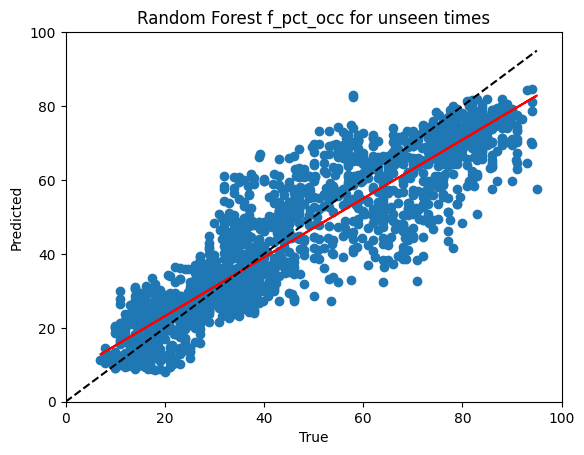

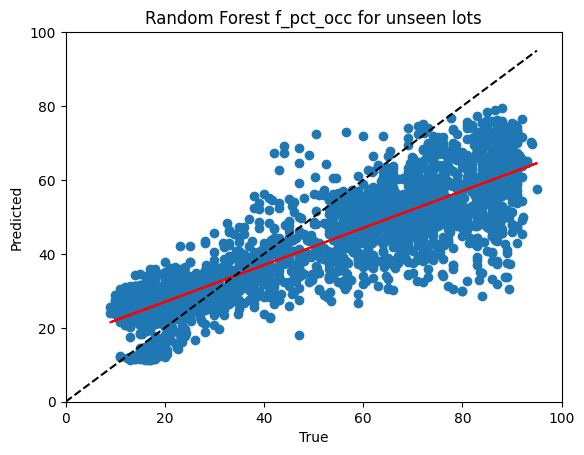

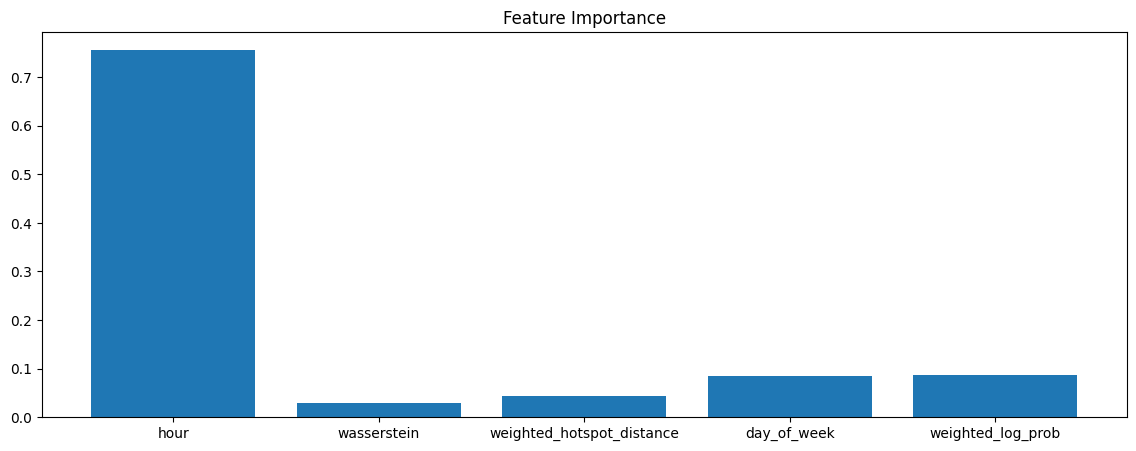

In [70]:
# visualize time results
plt.scatter(y_time_test, y_time_pred)
# line of best fit
m, b = np.polyfit(y_time_test, y_time_pred, 1)
plt.plot(y_time_test, m*y_time_test + b, color='red')
max_val = max(max(y_time_test), max(y_time_pred))
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')
if output_feature == 'f_pct_occ':
    plt.xlim(0, 100)
    plt.ylim(0, 100)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'Random Forest {output_feature} for unseen times')
plt.show()

# visualize lot results
plt.scatter(y_lot_test, y_lot_pred)
# line of best fit
m, b = np.polyfit(y_lot_test, y_lot_pred, 1)
plt.plot(y_lot_test, m*y_lot_test + b, color='red')
max_val = max(max(y_lot_test), max(y_lot_pred))
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')
if output_feature == 'f_pct_occ':
    plt.xlim(0, 100)
    plt.ylim(0, 100)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'Random Forest {output_feature} for unseen lots')
plt.show()

# plot feature importance
fig = plt.figure(figsize=(14, 5))
importance = model.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=[x for x in range(len(importance))], labels=input_features)
plt.title('Feature Importance')
plt.show()

Predicted time series for pk_lot 381381 from 2023-03-01 to 2023-03-31


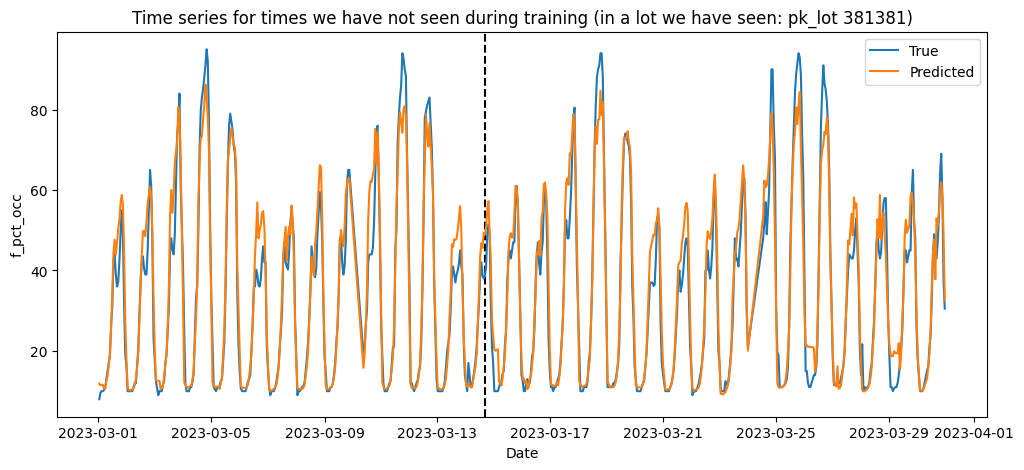

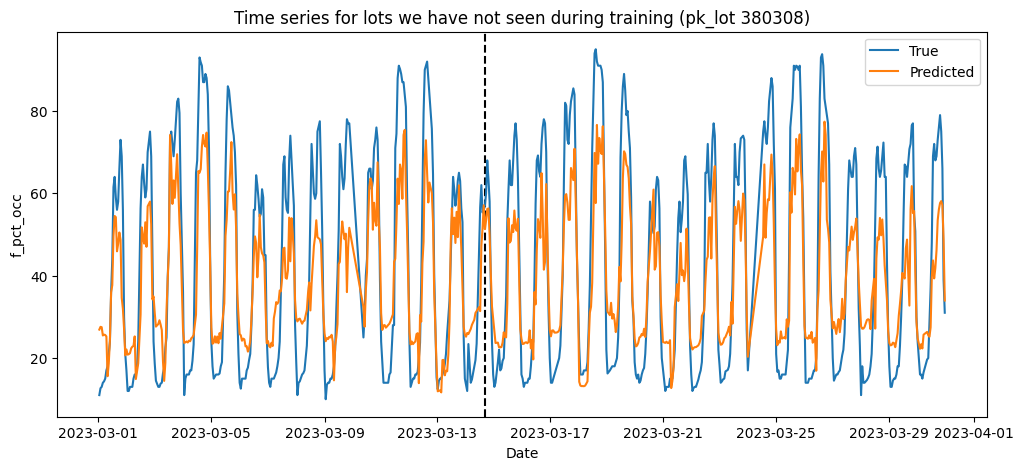

In [71]:
# plot the predicted time series for unseen time data
# get the first week of data for a random lot that we were trained on
train_lots = list(set(lot_ids) - set(test_lots))
lot_id = np.random.choice(train_lots)
start_date = '2023-03-01'
end_date = '2023-03-31'
week_df = df[(df['timestamp'] < end_date) & (start_date < df['timestamp']) & (df['pk_lot'] == lot_id)]
# sort week_df
week_df = week_df.sort_values(by=['timestamp'])
week = week_df[input_features].values
week = scaler.transform(week)
week_pred = model.predict(week)

print(f'Predicted time series for pk_lot {lot_id} from {start_date} to {end_date}')

fig = plt.figure(figsize=(12, 5))
# put a vertical line at test_day if the test_day is bteween strat_date and end_date
if start_date <= test_day <= end_date:
    plt.axvline(x=pd.to_datetime(test_day), color='black', linestyle='--')
plt.plot(week_df['timestamp'], week_df[output_feature], label='True')
plt.plot(week_df['timestamp'], week_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel(output_feature)
plt.title(f'Time series for times we have not seen during training (in a lot we have seen: pk_lot {lot_id})')
plt.legend()
plt.show()


# plot the predicted time series for unseen lot data
lot_id = np.random.choice(test_lots)
# start_date = '2022-12-10'
# end_date = '2023-02-10'
week_df = df[(df['timestamp'] < end_date) & (start_date < df['timestamp']) & (df['pk_lot'] == lot_id)]
# sort week_df
week_df = week_df.sort_values(by=['timestamp'])
week = week_df[input_features].values
week = scaler.transform(week)
week_pred = model.predict(week)

fig = plt.figure(figsize=(12, 5))
# put a vertical line at test_day if the test_day is bteween strat_date and end_date
if start_date <= test_day <= end_date:
    plt.axvline(x=pd.to_datetime(test_day), color='black', linestyle='--')
plt.plot(week_df['timestamp'], week_df[output_feature], label='True')
plt.plot(week_df['timestamp'], week_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel(output_feature)
plt.title(f'Time series for lots we have not seen during training (pk_lot {lot_id})')
plt.legend()
plt.show()
